In [ ]:
# ! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download divg07/casia-20-image-tampering-detection-dataset

 99% 2.54G/2.56G [00:28<00:00, 103MB/s]
100% 2.56G/2.56G [00:28<00:00, 97.3MB/s]


In [ ]:
! unzip casia-20-image-tampering-detection-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00045_arc00046_10084.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00045_arc00071_10087.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00046_arc00045_10083.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00054_cha00085_11922.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00071_arc00045_10085.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00073_arc00072_10267.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_arc00088_arc00064_10394.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00012_art00013_11812.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00014_art00013_11836.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00058_art00049_10529.tif  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00067_ani00093_11801.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00067_ani00095_11803.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00067_ani00096_11802.jpg  
  inflating: CASIA2/Tp/Tp_D_CRN_M_N_art00067_nat00013_11804.jpg  
  inflating: CASIA2/Tp/Tp

DATA PREPROCESSING 



In [ ]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from PIL import Image, ImageChops, ImageEnhance
from sklearn.utils import shuffle
import tensorflow as tf

#### Analysis on fake images 

In [ ]:
fake_image_data={'image_path':[],'label':[],'image_id':[]}

In [ ]:
fake_image_path='/content/CASIA2/Tp'
for img in os.listdir(fake_image_path) :
    if img.endswith('jpg') or img.endswith('png') :
      temp_path=fake_image_path+"/"+str(img)
      fake_image_data['image_path'].append(temp_path)
      fake_image_data['label'].append('fake')
      fake_image_data['image_id'].append(img[:-4])
    
    

In [ ]:
fake_image_data=pd.DataFrame(fake_image_data)
fake_image_data.head()

,image_path,label,image_id
0,/content/CASIA2/Tp/Tp_S_NRN_S_N_ind00072_ind00...,fake,Tp_S_NRN_S_N_ind00072_ind00072_10698
1,/content/CASIA2/Tp/Tp_S_NNN_S_N_cha00008_cha00...,fake,Tp_S_NNN_S_N_cha00008_cha00008_11157
2,/content/CASIA2/Tp/Tp_S_CRN_S_N_txt00048_txt00...,fake,Tp_S_CRN_S_N_txt00048_txt00048_11319
3,/content/CASIA2/Tp/Tp_S_NRN_S_N_art00003_art00...,fake,Tp_S_NRN_S_N_art00003_art00003_10755
4,/content/CASIA2/Tp/Tp_D_NRN_M_N_nat10126_cha00...,fake,Tp_D_NRN_M_N_nat10126_cha00063_11652


In [ ]:
print("Number of fake images are {}".format(fake_image_data.shape[0]))

Number of fake images are 2064


#### Analysis on Real images

In [ ]:
real_image_data={'image_path':[],'label':[],'image_id':[]}

In [ ]:
real_image_path='/content/CASIA2/Au'
for img in os.listdir(real_image_path) :
    if img.endswith('jpg') or img.endswith('png') :
      temp_path=real_image_path+"/"+str(img)
      real_image_data['image_path'].append(temp_path)
      real_image_data['label'].append('real')
      real_image_data['image_id'].append(img[:-4])
    
    

In [ ]:
real_image_data=pd.DataFrame(real_image_data)
real_image_data.head()

,image_path,label,image_id
0,/content/CASIA2/Au/Au_sec_30485.jpg,real,Au_sec_30485
1,/content/CASIA2/Au/Au_pla_00064.jpg,real,Au_pla_00064
2,/content/CASIA2/Au/Au_pla_30475.jpg,real,Au_pla_30475
3,/content/CASIA2/Au/Au_pla_30569.jpg,real,Au_pla_30569
4,/content/CASIA2/Au/Au_arc_30811.jpg,real,Au_arc_30811


In [ ]:
print("Number of real images are {}".format(real_image_data.shape[0]))

Number of real images are 7437


In [ ]:
real_image_data=shuffle(real_image_data,random_state=42)
real_image_data=real_image_data.iloc[:fake_image_data.shape[0],:]

In [ ]:
final_image_data=pd.concat([fake_image_data,real_image_data])

In [ ]:
print("Total number of images in dataset is {}".format(final_image_data.shape[0]))

Total number of images in dataset is 4128


##### IMAGE PREPROCESSING (ERROR LEVEL ANALYSIS)

In [ ]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file.jpg'
    ela_filename = 'temp_ela_file.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [ ]:
image_size = (128, 128)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 85).resize(image_size)).flatten() / 255.0

In [ ]:
X=[]
Y=[]

In [ ]:
for index,rows in tqdm(final_image_data.iterrows()) :
    temp_ela_image=prepare_image(rows['image_path'])
    X.append(temp_ela_image)
    if rows['label']=='fake' :
        Y.append(0)
    else :
        Y.append(1)

4128it [01:20, 51.06it/s]


In [ ]:
X, Y = shuffle(X, Y, random_state=42)

In [ ]:
X = np.array(X)
X = X.reshape(-1, 128, 128, 3)

TRAINING AND VALIDATION SET

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=42)

#### CUSTOM DATAGENERATOR

In [ ]:
class Dataset:
    def __init__(self, data_x,data_y):
        self.x = []
        self.y = []
        
        for img in data_x :
            self.x.append(img)
        
        for lab in data_y :
            self.y.append(lab)
            

    def __getitem__(self, i):
            
        return self.x[i],self.y[i]
        

    def __len__(self): 
        return len(self.x)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1,shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.indexes = np.arange(len(self.dataset.x))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        #batch = [for samples in zip(*data)]
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple([batch[0],batch[1]])

    def __len__(self):  
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

train_dataset=Dataset(X_train,Y_train)
train_dataloader = Dataloder(train_dataset, batch_size=8,shuffle=True)

In [ ]:
test_dataset=Dataset(X_val,Y_val)
test_dataloader = Dataloder(test_dataset, batch_size=8,shuffle=True)

#### MODEL BUILDING AND TRAINING

In [ ]:
from tensorflow.keras.layers import * 
from tensorflow.keras.models import *

In [ ]:
Input_shape=Input(shape=(128,128,3))
conv11=Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu")(Input_shape)
conv12=Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(conv11)
conv13=MaxPool2D(pool_size=(2,2),strides=(2,2))(conv12)
# conv13=Dropout(0.3)(conv13)

flatten1=Flatten()(conv13)
dense1=Dense(units=16,activation="relu")(flatten1)
dense2=Dense(units=8,activation="relu")(dense1)
output=Dense(units=1, activation="sigmoid")(dense2)

model=Model(inputs=Input_shape,outputs=output)

In [ ]:
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

##### Training the model

In [ ]:
def scheduler(epoch,lr) :
  if epoch%5==0 :
    lr=0.9*lr
  
  return lr

In [ ]:
#Callbacks 
lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
es=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)
rl=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=5)

In [ ]:
history=model.fit_generator(train_dataloader,steps_per_epoch=len(train_dataloader)//8,validation_data=test_dataloader,validation_steps=len(test_dataloader)//8,epochs=30,callbacks=[lrScheduler,es,rl])

Epoch 1/30


<ipython-input-30-ac15b3a9a262>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_dataloader,steps_per_epoch=len(train_dataloader)//8,validation_data=test_dataloader,validation_steps=len(test_dataloader)//8,epochs=30,callbacks=[lrScheduler,es,rl])


51/51 [==============================] - 15s 25ms/step - loss: 0.6829 - accuracy: 0.4877 - val_loss: 0.6617 - val_accuracy: 0.4792 - lr: 9.0000e-05
Epoch 2/30
51/51 [==============================] - 1s 24ms/step - loss: 0.6210 - accuracy: 0.6397 - val_loss: 0.5826 - val_accuracy: 0.6458 - lr: 9.0000e-05
Epoch 3/30
51/51 [==============================] - 1s 22ms/step - loss: 0.5334 - accuracy: 0.7696 - val_loss: 0.4982 - val_accuracy: 0.8333 - lr: 9.0000e-05
Epoch 4/30
51/51 [==============================] - 1s 20ms/step - loss: 0.4609 - accuracy: 0.8211 - val_loss: 0.4668 - val_accuracy: 0.7812 - lr: 9.0000e-05
Epoch 5/30
51/51 [==============================] - 1s 21ms/step - loss: 0.4638 - accuracy: 0.8162 - val_loss: 0.4553 - val_accuracy: 0.7917 - lr: 9.0000e-05
Epoch 6/30
51/51 [==============================] - 1s 20ms/step - loss: 0.3991 - accuracy: 0.8480 - val_loss: 0.4402 - val_accuracy: 0.8229 - lr: 8.1000e-05
Epoch 7/30
51/51 [==============================] - 1s 21ms/st

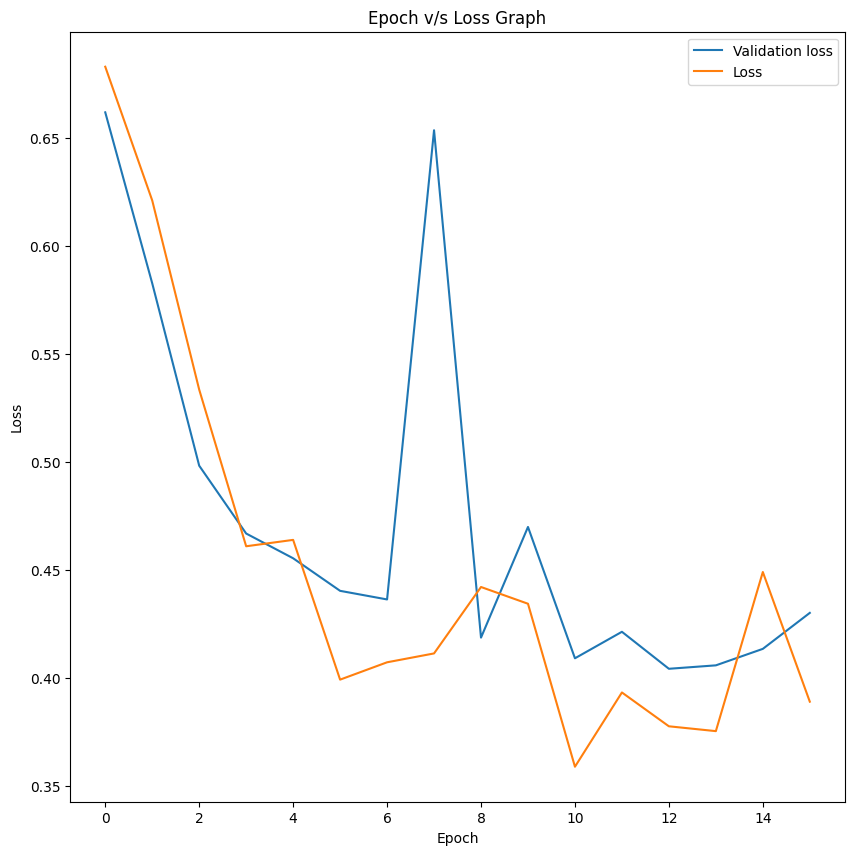

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history.history['val_loss'],label='Validation loss')
plt.plot(history.history['loss'],label='Loss')
plt.title("Epoch v/s Loss Graph")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model.save("model.h5")

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-decision-forests to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━

##### PREDICTION

In [ ]:
def predict(img_path,model) :
    pi=prepare_image(img_path)
    pi=pi.reshape(1,128,128,3)
    predict=model.predict(pi)
    return predict

In [ ]:
#Prediction on 5 random images 
for i in range(1,6) :
  ran_num=np.random.randint(0,final_image_data.shape[0])
  temp_row=final_image_data.iloc[ran_num,:]
  print("="*100)
  temp_arr=plt.imread(temp_row['image_path'])

  print("Real label--- {}".format(temp_row['label']))
  temp_predict=predict(temp_row['image_path'],model)
  if temp_predict[0]>0.5 :
    temp_prediction='real'
  else:
    temp_prediction='fake'
  print("Predicted label--- {}".format(temp_prediction))
